# **Identificación de Imágenes Auténticas y Sintéticas : Abordando los Desafíos de las Imágenes Sintéticas en la Sociedad Actual**

**Contenido**
1. [Configuración del Entorno](#title1)
2. [Construcción del Conjunto de Datos](#title2)
3. [Prueba de Diferentes Clasificadores](#title3)

## Configuración del Entorno<a name="title1"></a>

Importamos todas las librerías de uso.

In [12]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices("GPU"))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import glob
import cv2
from tensorflow.keras import layers, models
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_input_mobilenetv2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
import matplotlib.image as mpmig
from keras.utils import to_categorical
import os
sns.set_theme()

## Construcción del Conjunto de Datos y Preprocesandolos<a name="title2"></a>

Fuente: https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset
Importamos los archivos con los datos codificados en identificadores.

In [14]:
#Ruta de las imágenes
real_images_path = './Data/Train/Real'
fake_images_path = './Data/Train/Fake'
real_images_path_test = './Data/Test/Real'
fake_images_path_test = './Data/Test/Fake'

In [15]:
#Preprocesar imágenes (redimensionar, normalizar y asegurar formato RGB)
real_images = []
fake_images = []

# Función para cargar una imagen
def load_image(img_path):
    """
    Carga una imagen desde la ruta dada y convierte de BGR a RGB.
    """
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB
    return img

# Función para redimensionar una imagen
def resize_image(img, image_size=(178, 178)):
    """
    Redimensiona una imagen al tamaño especificado.
    """
    if img is not None:
        img = cv2.resize(img, image_size)
    return img

# Función para normalizar una imagen
def normalize_image(img):
    """
    Normaliza los valores de la imagen a [0, 1].
    """
    if img is not None:
        img = img / 255.0
    return img

In [16]:
# Cargar, redimensionar y normalizar imágenes
def process_images_from_folder(folder, image_size=(178, 178)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_image(img_path)  # Cargar imagen
        if img is not None:
            img = resize_image(img, image_size)  # Redimensionar
            img = normalize_image(img)  # Normalizar
            images.append(img)
    return images

# Modelo<a name="title3"></a>



Cargar la Data

In [18]:
# Procesar imágenes de entrenamiento
real_images_train = process_images_from_folder(real_images_path)
fake_images_train = process_images_from_folder(fake_images_path)

# Procesar imágenes de prueba
real_images_test = process_images_from_folder(real_images_path_test)
fake_images_test = process_images_from_folder(fake_images_path_test)

In [19]:
#Filtrar imágenes no válidas
real_images_train = [img for img in real_images_train if img is not None]
fake_images_train = [img for img in fake_images_train if img is not None]
real_images_test = [img for img in real_images_test if img is not None]
fake_images_test = [img for img in fake_images_test if img is not None]

#Convertir listas a arrays de NumPy
X_train = np.array(real_images_train + fake_images_train)
y_train = np.array([0] * len(real_images_train) + [1] * len(fake_images_train))  # Etiquetas: 0 = real, 1 = generada
X_test = np.array(real_images_test + fake_images_test)
y_test = np.array([0] * len(real_images_test) + [1] * len(fake_images_test))  # Etiquetas: 0 = real, 1 = generada

Crear el modelo

In [20]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(178, 178, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Salida binaria: 0 = real, 1 = generada
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-7)
# Añadir un scheduler de tasa de aprendizaje para ajustarla progresivamente
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(X_train_split, y_train_split, batch_size=32, epochs=100, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr, lr_scheduler])

In [22]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Precisión en el conjunto de prueba: {test_acc:.2f}')

41/41 - 0s - loss: 1.1959 - accuracy: 0.8697 - 331ms/epoch - 8ms/step
Precisión en el conjunto de prueba: 0.87


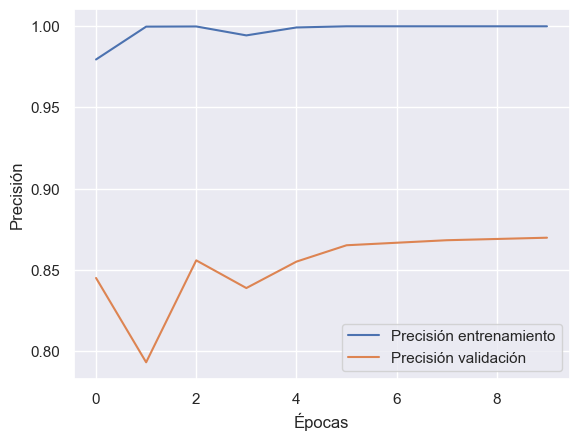

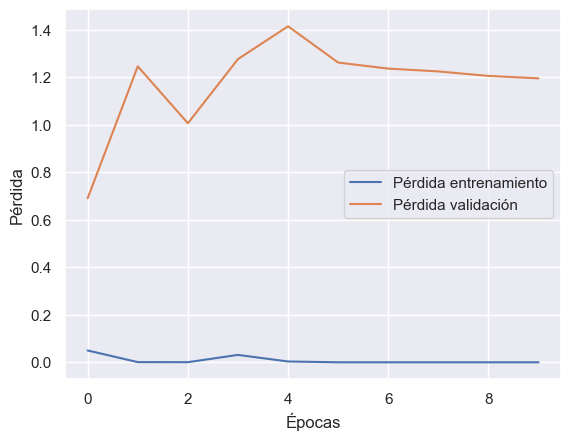

In [24]:
# Visualizar los resultados de entrenamiento
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()